# CA2 - ML on Agriculture in Ireland and EU

## Overview

In this notebook, ML techniques were applied on the following datasets related to the agriculture topic:

- Tweets dataset
- Crops and Livestock Products Import/Export

In the first part of the notebook, it was performed a sentiment analysis on the tweets collected about agriculture and food prices.

The tweets were pre-processed to extract their sentiment for two classification methods:

- Naive Bayes
- Logistic Regression

The following text processing techniques were also applied: Lemmatizer, Porter Stemmer, SMOTE, Tfidf and Count Vectorizer.

In the second part of this notebook, the following ML models were used to predict import/export of products in Ireland and other countries using the Crops and Livestock Products Import/Export dataset.

- Linear Regression
- KNN Regression

The following techniques were also applied K-Fold, GridSearchCV and Cross-Validation.

## Auxiliary Functions

In this section, the auxiliary functions used in this notebook were implemented.

The following requirement should be satisfied before running the code in this notebook:

- NLTK library should be installed: The code to install this lib is commented out in the code below.

In [20]:
# adding modules folder to the path
import sys
sys.path.append('./modules')

# importing constants and modules created for this project
from constants import *
from text_processor import *
from json_helper import *

# uncomment to install any missing lib
# !pip install wordcloud
# !pip install textblob
# !pip install punkt
# import nltk
# nltk.download()

# importing modules specific to this notebook
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob 
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline

# setting constants for this notebook
DEFAULT_CV = 5
DEFAULT_RS = 42
DEFAULT_TEST_SIZE = .3
MAX_FEATURES = 5000

# use a logger to help debugging
logger = logging.getLogger('ml')

# set logger level
logger.setLevel(logging.ERROR)

def get_freq(df, colname):
    '''
    Auxiliary function to calculate the frequency distribution of the words in a column.

    Parameters:
        df (DataFrame): Data frame to be processed.
        colname  (str): Column name to get its frequency calculated.
    Returns:
        fdist    (mtx): Frequency distribution of the tokens.
    '''
    tokens_lst = []
    for i in range(0, len(df)):
        text = df.loc[i][colname]
        tokens_lst+= TextProcessor.get_tokens(text)

    fdist = FreqDist(tokens_lst)

    return fdist

def wordcloud_draw(data, color='black'):
    '''
    Auxiliary function to generate a word cloud from the data.

    Parameters:
        data (DataFrame): Data frame to be processed.
        color      (str): Background color.
    '''
    words = ' '.join(data)
    wordcloud = WordCloud(background_color=color, width=2500, height=2000).generate(words)
    plt.figure(1,figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def is_valid_vectorizer(obj):
    '''
    Auxiliary function to validate the vectorizer object.

    Parameters:
        obj (obj): Instance of a vectorizer to be validated.
    Returns:
        True if valid, False otherwise.
    '''
    if isinstance(obj, TfidfVectorizer):
        return True
    if isinstance(obj, CountVectorizer):
        return True
    return False
    
def run_text_vectorizer(df, x_name, vec_inst, max_f=MAX_FEATURES):
    '''
    Auxiliary function to run the text vectorizer passed in the input.

    Parameters:
        df (DataFrame): Data frame to be processed.
        x_name   (str): Name of the column to be processed.
        vec_inst (obj): Text vectorizer instance to be used.
    Returns:
        x_vec    (arr): Feature vector extracted from each text in the processed column.
    '''
    if not is_valid_vectorizer(vec_inst):
        raise Exception(f'Not a valid vectorizer! { type(vec_inst) }')

    # getting feat vectors for x_name
    x_vec = vec_inst.fit_transform(df[x_name]).toarray()

    logger.info(f'Feature vector using { type(vec_inst) }: { x_vec.shape }')

    return x_vec

def resample(X, y):
    '''
    Auxiliary function that uses SMOTE technique to resample the input data.
    
    Parameters:
        X (Data Series): Independent variable to be resampled based on the target balance.
        y (Data Series): Target variable to be balanced.
    Returns:
        X_res, y_res: Balanced dataset.
    '''
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res
    
def run_naive_bayes_classifier_cross_val(X, y, cv=DEFAULT_CV):
    '''
    Auxiliary function to run Naive Bayes classifier using cross validation.

    Parameters:
        X (Series): X variable data.
        y (Series): y Target variable data.
        cv   (int): Number of folds to be used by cross validation function.
    Returns:
        cv_res (dict): Results of the cross validation score method.
    '''  
    model = MultinomialNB()    
    cv_res = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    return cv_res
    
def run_naive_bayes_classifier(X, y):
    '''
    Auxiliary function to run Naive Bayes classifier.

    Parameters:
        X (Series): X variable data.
        y (Series): y Target variable data.
    Returns:
        cf (dict): Results of the classifier.
    '''
    # instantiate a naive bayes model classifer
    model = MultinomialNB()

    # split the dataset into training and testing parts
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=DEFAULT_TEST_SIZE, random_state=DEFAULT_RS)

    # train the model by calling a method fit()
    model.fit(X_train, y_train)

    # predict test data using the model
    y_pred = model.predict(X_test)

    # getting classification report from the model
    cf = classification_report(y_test, y_pred, target_names=sentiment_lst)

    return cf

def run_min_max_scaler(df, colslist=[]):
    '''
    This function applies the min/max scaler to the specified columns.

    Parameters:
        df (DataFrame): Dataset.
        colslist (lst): List of columns to apply the scaler.
    Returns:
        df_scaler: scaled dataset
    '''
    # recaling the variables (both)
    df = df[colslist]
    scaler = MinMaxScaler()
    df_scaler = scaler.fit_transform(df)

    # rename columns (since now its an np array)
    df_scaler = pd.DataFrame(df_scaler)
    df_scaler.columns = colslist
    return df_scaler

def run_grid_search_cv(model, X, y, scoring, param_grid):
    '''
    This functions executes GridSearchCV on the specified model to get the best parameters.
    
    Parameters:
        model       (obj): ML model to run.
        X     (DataFrame): Independent variables.
        y     (DataFrame): Target variable.
        scoring     (str): Scoring name.
        param_grid (dict): Params to be tried.
    Returns:
        df_scaler: scaled dataset    
    '''
    # set kfold object with 10 splits
    folds = KFold(n_splits=10, shuffle=True, random_state=DEFAULT_RS)
    
    # configuring grid search cv
    grid = GridSearchCV(model, param_grid, cv=folds, scoring=scoring, return_train_score=True, verbose=1)

    # fitting the model for grid search
    grid_search = grid.fit(X, y)

    return grid_search

def get_model_instance(model_name, param):
    '''
    Return an instance of the specified model if supported.
    
    Params:
        model_name (str): Name of the model (supported: knn, lr)
        param (int): Parameter of the model (supported: degree or k value)
    Returns:
        instance of the model
    '''
    if model_name == 'knn':
        return KNeighborsRegressor(n_neighbors=param)

    elif model_name == 'lr':
        return make_pipeline(PolynomialFeatures(param), LinearRegression())

    raise Exception(f'Model {model_name} not supported!')

def run_model(model, X_train, y_train, X_test, y_test, scoring, cv=DEFAULT_CV):
    '''
    This function runs a ML model independently to get results from its predict method.
    
    It also calculates the score based on the cross validation results using the test and train data.

    Parameters:
        model: ML model to run.
        X_train: x train dataset.
        y_train: y train dataset.
        X_test: X test dataset.
        y_test: y test dataset.
        scoring: Scoring function name.
    Returns:
        tuple: y_train_pred, y_test_pred, avg r2_score_train, avg r2_score_test
    '''
    # getting score from cross validation
    scores_train = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, error_score='raise')
    scores_test = cross_val_score(model, X_test, y_test, cv=cv, scoring=scoring, error_score='raise')

    # predict on test and train data
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return y_train_pred, y_test_pred, float(np.mean(scores_train)), float(np.mean(scores_test))

def train_test_split_batch(X, y, n_exec=1, ts=DEFAULT_TEST_SIZE, rs=DEFAULT_RS):
    '''
    Split dataset into train and test data for n executions of the desired model.
    
    Create an output structure to store the predicted y values from each execution of the model.

    Parameters:
        X (DataFrame): Independent variables from the dataset.
        y (DataFrame): Target variable from the dataset.
        ts    (float): Percent of dataset to be used for test.
        rs      (int): Random state.
    Returns:
        X_train, X_test, y_train, y_test, y_train_pred, y_test_pred
    '''
    # splitting data into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=rs)

    # reshape X train and test data
    X_train = X_train.values.reshape(-1, 1)
    X_test = X_test.values.reshape(-1, 1)

    # creating y train and test result structure for each execution result
    y_train_pred = np.zeros((len(X_train), n_exec))
    y_test_pred = np.zeros((len(X_test), n_exec))

    return X_train, X_test, y_train, y_test, y_train_pred, y_test_pred

def get_r2_score_batch(target_name, y_train, y_train_pred, y_test, y_test_pred, param_list, cv_score_res):
    '''
    Calculate R2 score based on the input and generate a result dataset.

    Parameters:
        target_name        (str): Y target variable name.
        y_train      (DataFrame): Train y data from the dataset.
        y_train_pred (DataFrame): Train y data predicted using the model.
        y_test       (DataFrame): Test y data from the dataset.
        y_test_pred  (DataFrame): Test y data predicted using the model.
        param_list         (lst): Param values to execute the model.
        cv_score_res       (lst): Cross validation score previously calculated for the train and test dataset.
    Returns:
        r2_batch_res (lst): Output R2 score results.
    '''
    # generating r2 score results per tested param
    r2_batch_res = []

    # calculating the r2 score for each execution of the model with the selected parameter
    for i, param in enumerate(param_list):
        # getting r2 score for the train set
        train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
        # getting r2 score for the test set
        test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, i]), 2)
        # appending the results to the data structure        
        r2_batch_res.append([target_name, param, train_r2, test_r2, cv_score_res[i][0], cv_score_res[i][1]])

    return r2_batch_res

def run_model_batch(model_name, X, y, target_name, params, ts=DEFAULT_TEST_SIZE):
    '''
    Run the same model with different values of params passed as input.

    Parameters:
        model       (str): Model name (supported: knn, lr).
        X     (DataFrame): Independent variables from the dataset.
        y     (DataFrame): Target variable from the dataset.
        target_name (str): Y target variable name.
        k           (lst): List of K values to be tested.
    Returns:
        lr_results, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred
    '''
    # getting train and test data for multiple executions of the model with diff parameters
    X_train, X_test, y_train, y_test, y_train_pred, y_test_pred = train_test_split_batch(X, y, len(params), ts)

    # running the model with each parameter to get the predicted values and the cv score from test and train data
    cv_score_res = []
    for i in range(0, len(params)):
        model = get_model_instance(model_name, params[i])
        y_train_pred_i, y_test_pred_i, cv_score_train, cv_score_test = run_model(model, X_train, y_train, X_test, y_test, 'r2')
        y_train_pred[:, i] = y_train_pred_i
        y_test_pred[:, i]  = y_test_pred_i
        cv_score_res.append([cv_score_train, cv_score_test])

    # generate the validation results per parameter using r2 score
    lr_results = get_r2_score_batch(target_name, y_train, y_train_pred, y_test, y_test_pred, params, cv_score_res)

    # return tuple with the results and predicted values for train and test datasets
    return lr_results, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred

def plot_model_results(to_plot, graph_title, legend_title, params):
    '''
    Plot the regression model results based on each parameter from the list.

    Parameters:
        to_plot      (lst): List of results to plot. It's expected a tuple with X_res, y_res and y_res_pred with different results per param.
        graph_title  (str): Title of the graph.
        legend_title (str): Title of the legend.
        params       (lst): List of params used to run the model.
    '''
    # setting figure parameters
    plt.figure(figsize=(16, 5))
    subplot = 121

    # create graph for each train and test data
    for idx in range(0, len(to_plot)):
        # setting graph labels and parameters
        plt.subplot(subplot)
        plt.xlabel('Time')
        plt.ylabel(target)
        plt.yscale('log')
        plt.title(f'{labels[idx]}')
        plt.suptitle(graph_title)

        # getting data to plot (train or test)
        X_res, y_res, y_res_pred = to_plot[idx]

        # plotting original dataset
        plt.scatter(X_res, y_res, label=labels[idx])

        # plotting result of the regression
        for i, par in enumerate(params): 
            plt.scatter(X_res, y_res_pred[:, i], s=15, label=f'{str(par)}')

        # adding legend to the graph
        plt.legend(loc='best', title=legend_title)
        subplot+=1

def plot_results_dict(res_df, model_name, y_list, colors, title, x='Param'):
    '''
    Auxiliary function to plot the results graphs.
    
    Parameters:
        res_df     (DataFrame): Data frame with the results to plot.
        model_name       (str): Model name.
        y_list           (lst): y param list ot plot.
        colors           (lst): List of colors for the graph.
        x                (str): X param name to plot.
    '''
    # create the grid to display the import and export data
    perf_grid = sns.FacetGrid(res_df[res_df['Model'] == model_name], row='Area', col='Element',
                              height=5, aspect=1.5, sharey=False, sharex=False)
    
    for i, y in enumerate(y_list):
        # map the above form facetgrid with some attributes
        perf_grid.map(sns.lineplot, x, y, alpha=.8, linewidth=2.5, color=colors[i], label=y)

    # adding legend
    perf_grid.add_legend(fontsize='x-large')

    # adjusting space between graphs
    perf_grid.fig.subplots_adjust(wspace=.2, hspace=.2)

    # setting labels and titles
    perf_grid.set_xlabels('Param')
    perf_grid.set_ylabels('Accuracy')
    
    # setting title
    perf_grid.set_titles(title)

## Sentiment Analysis

In this section, the Twitter API was used to retrieve recent tweets about agriculture for the sentiment analysis.

The tags used for this search were inflation, food price and agriculture in an attempt to get agriculture related tweets.

The question being solved by this analysis was how to classify the sentiment of the tweets based on past data.

Thus, Naive Bayes and Logistic Regression algorithms were used to perform the sentiment classification.

### Data Preparation and Visualization

The data preparation steps on this dataset were implemented in its respective section of the DataPrepVis Jupyter notebook.

Thus, the processed datasets were used directly in this notebook.

In [2]:
# getting the processed tweets dataset
tweets_df = pd.read_csv(join(DATA_PREP_FOLDER, TWEETS_DATASET), encoding='utf-8')
tweets_df.head()

,tweet_raw,sent_raw,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm,tweet_str,sent_str
0,British public were treated like mugs..lied to...,negative,british public treated like mugs lied sold riv...,neutral,british public treat like mug lie sold river p...,positive,british public treated like mugs lied sold riv...,positive,british public were treated like mugs lied to...,negative
1,EU economies set to contract in 2023 - Financi...,positive,eu economies set contract financial times acco...,positive,eu economi set contract financi time accord ex...,positive,eu economies set contract financial times acco...,positive,eu economies set to contract in financi...,positive
2,Big big good news for all #Europe and #USA in ...,negative,big big good news europe usa cold season natur...,positive,big big good news europ usa cold season natura...,positive,big big good news europe usa cold season natur...,positive,big big good news for all europe and usa in su...,negative
3,"""The measures, coupled with an agreement negot...",positive,measures coupled agreement negotiated european...,positive,measur coupl agreement negoti european union p...,negative,measures coupled agreement negotiated european...,positive,the measures coupled with an agreement negot...,positive
4,It was due to the problems of Europe (Covid-19...,positive,due problems europe covid russia ukraine war r...,positive,due problem europ covid russia ukrain war rece...,positive,due problems europe covid russia ukraine war r...,positive,it was due to the problems of europe covid ...,positive


#### Data Description

The raw tweets were processed and the following columns were generated:

- tweet_raw, sent_raw: Original tweets + sentiment.

- tweet_str, sent_str: Tweets after the removal of special characters, urls and images + sentiment.

- tweet_clr, sent_clr: Tweets after the removal of stop words + sentiment.

- tweet_st, sent_st: Tweest after Porter Stemmer + sentiment.

- tweet_lm, sent_lm: Tweet after Lemmatizer + sentiment.

The sentiment was calculated for each version of the tweet because it was observed the results were different.

The possible sentiments were: positive, negative and neutral.

#### Handling Duplicates and Unbalanced Data

It was observed that after applying the text processing on the tweets, duplicates were generated. For example, tweet_clr has 171 distinct rows from 200 total rows.

That was handled when the ML models were applied in the experiments.

In [3]:
# investigating the characteristics of the dataset
tweets_df.describe()

,tweet_raw,sent_raw,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm,tweet_str,sent_str
count,200,200,200,200,200,200,200,200,200,200
unique,200,3,171,3,171,3,171,3,178,3
top,British public were treated like mugs..lied to...,positive,inflation baltics warning rest europe,positive,inflat baltic warn rest europ,neutral,inflation baltics warning rest europe,positive,inflation in the baltics a warning for the re...,positive
freq,1,74,22,70,22,83,22,77,19,73


It was also observed there were more positive hits than any other sentiment classes, as shown in the code below.

In [4]:
# checking if target variables are balanced
y_lst = ['sent_str', 'sent_clr', 'sent_st', 'sent_lm']
for i in range(0, len(y_lst)):
    print(f'Original dataset shape for { y_lst[i] } -> { Counter(tweets_df[y_lst[i]]) }')

Original dataset shape for sent_str -> Counter({'positive': 73, 'negative': 66, 'neutral': 61})
Original dataset shape for sent_clr -> Counter({'positive': 70, 'neutral': 66, 'negative': 64})
Original dataset shape for sent_st -> Counter({'neutral': 83, 'positive': 62, 'negative': 55})
Original dataset shape for sent_lm -> Counter({'positive': 77, 'neutral': 62, 'negative': 61})


The unbalanced data was handled by using SMOTE technique as demonstraded below, which balances the data so that the frequency of the classes doesn't impact the ML models.

In [5]:
# getting X, y data to test SMOTE method
X_smote = run_text_vectorizer(tweets_df, 'tweet_str', TfidfVectorizer())
y_smote = tweets_df['sent_str'].apply(lambda x: sentiment_lst.index(x))

# applying SMOTE to resample data
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X_smote, y_smote)

# printing results
print('Original dataset shape %s' % Counter(y_smote))
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({2: 73, 0: 66, 1: 61})
Resampled dataset shape Counter({0: 73, 2: 73, 1: 73})


#### Dataset Word Frequency

In order to visualize the data, it was prepared a frequency graph to show the most common words.

For this purpose it was used a tokenizer algorithm to generate tags from all the tweets after the cleanning stage.

The frequency was the same if Stemmer or Lemmatizer techniques were applied, so the following graph only shows the frequency of the cleaned tweet data.

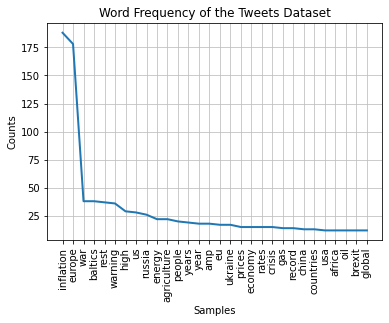

<AxesSubplot:title={'center':'Word Frequency of the Tweets Dataset'}, xlabel='Samples', ylabel='Counts'>

In [6]:
# display the frequency distribution
fdist = get_freq(tweets_df, 'tweet_clr')
fdist.plot(30, cumulative=False, title='Word Frequency of the Tweets Dataset')

#### Dataset Word Cloud

Another way to visualize text datasets is by using word clouds which facilitates the observation of the most frequent words.

It is evident the word 'inflation' is the most common in this dataset. Based on the other words, some Twitter users are also relating agriculture with the Russian war on Ukraine.

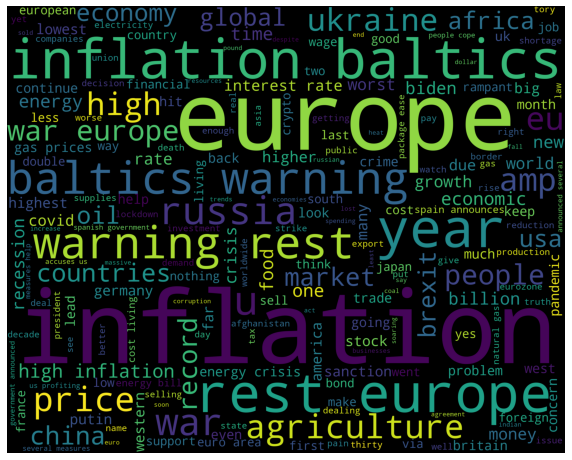

In [7]:
wordcloud_draw(tweets_df['tweet_clr'])

### Naive Bayes

Since every word can be treated as independent and makes equal contribution to the result, Naive Bayes technique can be used.

In order to apply that classifier, the texts were tokenized and a feature vector was extracted from each document (i.e., tweet).

From the data prepatation step, four versions of tweets were generated from the raw text: cleaned (keeping stop words), cleaned (no stop words), lemmatized and stemmerized tweets.

The classifier was executed over the different versions of tweets and two types of vectorizers: Tfidf and Count. Thus, the results were compared.

The model run with cross validation technique in which 10 folds were generated from the dataset. The average accuracy was calculated from each test execution.

Resampled dataset shape Counter({0: 73, 2: 73, 1: 73})
Resampled dataset shape Counter({0: 73, 2: 73, 1: 73})
Resampled dataset shape Counter({1: 69, 2: 69, 0: 69})
Resampled dataset shape Counter({1: 69, 2: 69, 0: 69})
Resampled dataset shape Counter({2: 61, 0: 61, 1: 61})
Resampled dataset shape Counter({2: 61, 0: 61, 1: 61})
Resampled dataset shape Counter({2: 76, 0: 76, 1: 76})
Resampled dataset shape Counter({2: 76, 0: 76, 1: 76})
           CountVectorizer  TfidfVectorizer                tp_approach
tweet_clr         0.567143         0.682857    Cleaned (no stop words)
tweet_lm          0.570356         0.720553                 Lemmatizer
tweet_st          0.481287         0.525146                    Stemmer
tweet_str         0.639827         0.712771  Cleaned (with stop words)


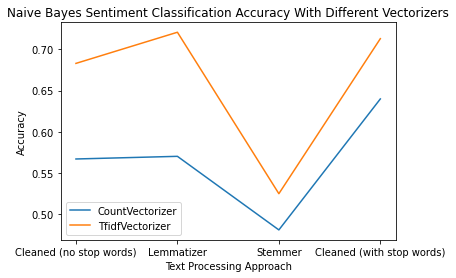

In [8]:
# independent variables to be tested from the dataset
X_names = ['tweet_str', 'tweet_clr', 'tweet_st', 'tweet_lm']
# target variables for each column to be tested
y_names = ['sent_str', 'sent_clr', 'sent_st', 'sent_lm']
# vectorizer names for readability
vt_names = ['TfidfVectorizer', 'CountVectorizer']
# vectorizer instances to be used
vt_inst = [TfidfVectorizer(max_features=5000), CountVectorizer(max_features=5000)]

# running Naive Bayes for each tweet column
results = {}
for i in range(0, len(X_names)):
    results[X_names[i]] = {}

    # trying different vectorizers
    for t in range(0, len(vt_inst)):
        vect = vt_inst[t]

        # remove duplicates from x
        tweets_df_no_dup = tweets_df.drop_duplicates(subset=[X_names[i]])

        # running vectorized on the X data
        X = run_text_vectorizer(tweets_df_no_dup, X_names[i], vect)

        # converting sentiment text into numbers on the y data
        y = tweets_df_no_dup[y_names[i]].apply(lambda x: sentiment_lst.index(x))

        # data is not balanced, applying SMOTE technique to resample
        X, y = resample(X, y)

        # running the classifier with cross validation
        cf = run_naive_bayes_classifier_cross_val(X, y, 10)

        # running the classifier to get precision/recall report
        #print(run_naive_bayes_classifier(X, y))

        # storing the mean of the k folds tested
        results[X_names[i]][vt_names[t]] = cf.mean()

# convert results into dataframe
res_json = JsonHelper(results).to_string()
results_df = pd.read_json(res_json, orient ='index')

# mapping columns to the text processing approach used
tp_approach = {'tweet_str': 'Cleaned (with stop words)', 'tweet_clr': 'Cleaned (no stop words)', 'tweet_lm': 'Lemmatizer', 'tweet_st': 'Stemmer'}
results_df['tp_approach'] = results_df.index.to_series().map(tp_approach)

# plotting the accuracy of the classifier using different vectorizers and NLP
plt.title('Naive Bayes Sentiment Classification Accuracy With Different Vectorizers')
plt.xlabel('Text Processing Approach')
plt.ylabel('Accuracy')
plt.plot(results_df['tp_approach'], results_df['CountVectorizer'], label='CountVectorizer')
plt.plot(results_df['tp_approach'], results_df['TfidfVectorizer'], label='TfidfVectorizer')
plt.legend()

print(results_df)

Based on the results above, the Naive Bayes approach on the Lemmatized tweets using Tfidf Vectorizer provided better accuracy of about 72%.

The lowest accuracy obtained was about 48% by using Stemmer and Count Vectorizer on this dataset.

Stemmer approach produced the lowest accuracy on both vectorizer methods. 

Also, keeping the stop words produced better results than removing them in both cases.

### Logistic Regression

Logistic Regression (LR) algorithm was also tested against the dataset because of its efficiency in predicting classes based on the features relationships.

In this experiment, GridSearchCV was applied to decide the best parameters to run the LR model as follows:

For this analysis, the main parameters tested were related to the vectorizer strategy as follows:

- Whether or not to filter out stop words.
- Which tokenizer was best: Tokens only, Stemmer or Lemmatizer.

Since the test involved deciding whether or not to use the stop words, the tweet_str column was used.

The SMOTE technique was also added to the pipeline to avoid noise given by unbalanced data.

The vectorizer applied in this test was the TfidfVectorizer because it was the approach that gave better results in the previous test.

In [9]:
# will use strip tweet with stop words to test the best words to remove
stop = stopwords.words('english')

# using the TfidfVectorizer tokenizer
vect = TfidfVectorizer(max_features=5000)

# setting up the pipeline steps: vectorize, smote and classification
lr = imbpipeline(steps = [['vect',  vect],
                          ['smote', SMOTE(random_state=11)],
                          ['clf',   LogisticRegression(random_state=42, max_iter=1000)]])

# testing vectorizer and classifier parameters
param_grid = [{'vect__stop_words': [stop, None],
               'vect__tokenizer': [TextProcessor.get_tokens, TextProcessor.apply_stemmer, TextProcessor.apply_lemmatizer],
               'vect__use_idf':[True, False],
               'vect__norm':[None, 'l1', 'l2'],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]}]

# using GridSearchCV to obtain the best parameters to test LR on tunned Tfidf vectorizer
gs_lr = GridSearchCV(lr, param_grid, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)

# remove duplicates from x
tweets_df_no_dup = tweets_df.drop_duplicates(subset=['tweet_str'])

# getting X, y data to run the classifer
X = tweets_df_no_dup['tweet_str']
y = tweets_df_no_dup['sent_str'].apply(lambda x: sentiment_lst.index(x))

# getting training test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# running param tunning on train data
gs_lr.fit(X_train, y_train)

# getting the results
clf = gs_lr.best_estimator_

print(f'Using { vt_names[0] }')
print('Best parameter set: %s ' % gs_lr.best_params_)
print('CV Accuracy: %.3f' % gs_lr.best_score_)
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Using TfidfVectorizer
Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__norm': 'l2', 'vect__stop_words': None, 'vect__tokenizer': <function TextProcessor.apply_stemmer at 0x000001A474B63160>, 'vect__use_idf': True} 
CV Accuracy: 0.549
Test Accuracy: 0.481


### Results

Logistic Regression provided poorer results compared to the Naive Bayes approach. Its accuracy with the parameters given by GridSearchCV was just 55%.

Interesting to note that the result from GridSearchCV was given by using stop words and Stemmer technique, which differs from the approach that gave better results in the previous experiment.

## Crops and Livestock Products Import/Export Prediction

FAO provides data on the import/export of crops and livestocks products from several countries with data ranging from 1961 up to 2020.

The main elements tracked are the import and export quantity, in tonnes, and value, in 1000 US$.

Finland and Ireland have about the same population according to the <a href="https://worldpopulationreview.com/continents/europe-populationhttps://worldpopulationreview.com/continents/europe-population">World Population Review website</a>, so for the scope of this project it was assumed they are similar countries.

In this part, the crops and livestock dataset was analyzed using ML technniques to make predictions about the average import/export data in Ireland and Finland.

The base question was: What is the import/export forecast in Ireland as compared with Finland for the next years?

### Data Preparation and Visualization

The data preparation steps on this dataset were implemented in its respective section of the DataPrepVis Jupyter notebook.

Thus, the processed datasets were used directly in this notebook.

In [10]:
# getting average import dataset
imp_data_avg = pd.read_csv(join(DATA_PREP_FOLDER, IMP_DATASET_AVG), encoding='utf-8')
imp_data_avg.head()

,Year,Element,Area,Area Code (M49),Element Code,Year Code,Value
0,1961,Import Value,Finland,246.0,5622.0,1961.0,529.840909
1,1961,Import Value,Ireland,372.0,5622.0,1961.0,471.682081
2,1962,Import Value,Finland,246.0,5622.0,1962.0,564.987013
3,1962,Import Value,Ireland,372.0,5622.0,1962.0,473.291908
4,1963,Import Value,Ireland,372.0,5622.0,1963.0,528.546243


In [11]:
# getting average export dataset
exp_data_avg = pd.read_csv(join(DATA_PREP_FOLDER, EXP_DATASET_AVG), encoding='utf-8')
exp_data_avg.head()

,Year,Element,Area,Area Code (M49),Element Code,Year Code,Value
0,1961,Export Value,Finland,246.0,5922.0,1961.0,168.884328
1,1961,Export Value,Ireland,372.0,5922.0,1961.0,1027.138037
2,1962,Export Value,Finland,246.0,5922.0,1962.0,151.507463
3,1962,Export Value,Ireland,372.0,5922.0,1962.0,963.840491
4,1963,Export Value,Finland,246.0,5922.0,1963.0,177.235075


In order to apply the ML prediction models on these datasets, they had to be converted into timeseries.

Therefore, the quantity and value rows from the dataset were scaled and a dummy time index column was created for each of the following pairs per country: import-quantity, import-value, export-quantity, export-value.

The timeseries were created for each country. Threfore, 8 smaller datasets were created, for instance, Import Quantity Ireland, Import Value Ireland, etc.

The following graphs were generated to illustrate the datasets after that pre-processing step.

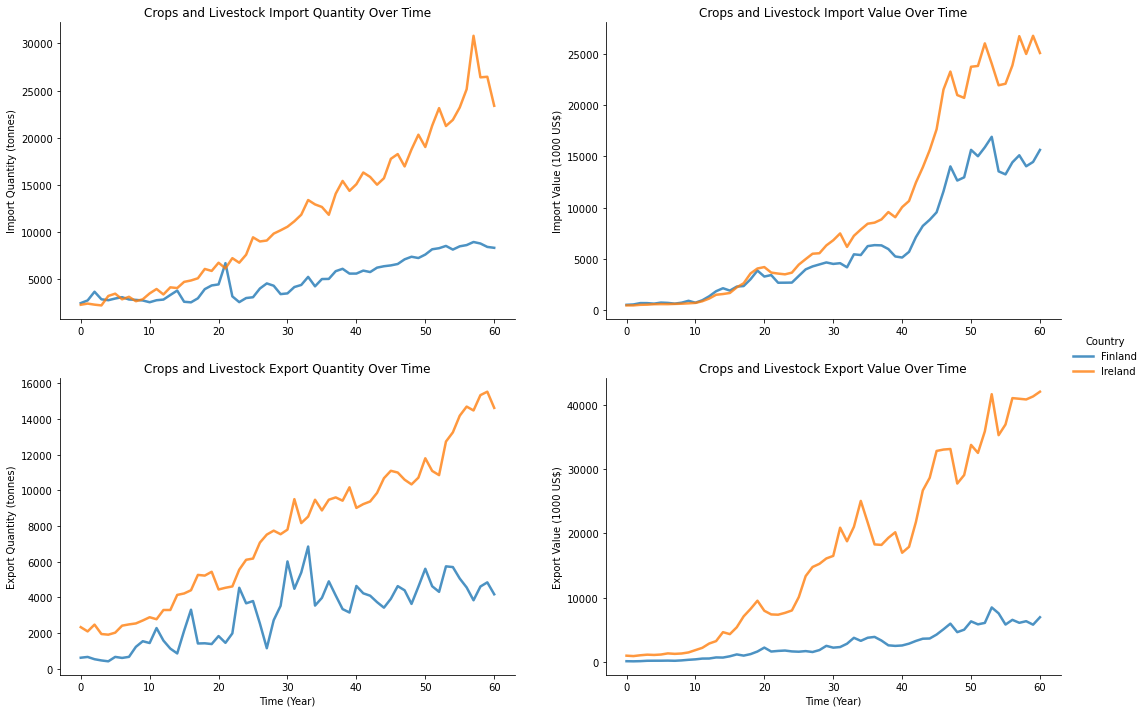

In [12]:
# concat the datasets to facilitate processing
imp_exp_avg_df = pd.concat([imp_data_avg, exp_data_avg])

# removing Slovakia data
imp_exp_avg_df = imp_exp_avg_df[imp_exp_avg_df['Area'] != 'Slovakia']

# getting the list of countries for the analysis
countries = list(imp_exp_avg_df['Area'].unique())

# getting the list of elements
elements = ['Import', 'Export']

# getting the list of measurements
measures = ['Quantity', 'Value']

# store each country import export timeseries in the list
imp_exp_ts_datasets = []

# collect dat for each country
for c in countries:
    # getting specific country dataset
    imp_exp_c_df = imp_exp_avg_df[imp_exp_avg_df['Area'] == c]
    
    # adjusting Slovakia's data to be comparable to other countries
    delta = 0
    if c == 'Slovakia':
        delta = 32

    # for each import/export dataset
    for el in elements:
        el_c_df = imp_exp_c_df[imp_exp_c_df['Element'].str.contains(el)]

        # apply scaler and add dummy time column to each dataset
        for ms in measures:
            ms_el_c_df = el_c_df[el_c_df['Element'].str.contains(ms)]
            
            # adding dummy index for the time series
            ms_el_c_df['Time_Index'] = np.arange(len(ms_el_c_df.index))

            # scaling the dataset - has to be done in the specific dataset
            ms_el_c_df_scaler = run_min_max_scaler(ms_el_c_df, ['Value'])
            ms_el_c_df.assign(Value=ms_el_c_df_scaler.Value)
            
            # adjusting delta as Slovakia's observations started from 1993
            ms_el_c_df['Time_Index'] = ms_el_c_df['Time_Index'] + delta

            # append timeseries to the list
            imp_exp_ts_datasets.append(ms_el_c_df)

# getting all timeseries per country per import/export val and quantity into the same dataframe
imp_exp_ts = pd.concat(imp_exp_ts_datasets)

# create the grid to display the import and export data
imp_exp_grid = sns.FacetGrid(imp_exp_ts, col='Element', hue='Area', 
                             height=5, aspect=1.5, sharey=False, sharex=False, col_wrap=2)

# map the above form facetgrid with some attributes
imp_exp_grid.map(sns.lineplot, 'Time_Index', 'Value', alpha=.8, linewidth=2.5)

# adding legend
imp_exp_grid.add_legend(title='Country')

# setting labels and titles
imp_exp_grid.set_xlabels('Time (Year)')
imp_exp_grid.set_titles('Crops and Livestock {col_name} Over Time')

# adjusting space between graphs
imp_exp_grid.fig.subplots_adjust(wspace=.2, hspace=.2)

# iterate thorugh each axis
y_labels = ['Import Quantity (tonnes)', 'Import Value (1000 US$)', 'Export Quantity (tonnes)', 'Export Value (1000 US$)']
idx = 0
for ax in imp_exp_grid.axes.flat:
    ax.set_ylabel(y_labels[idx])
    ax.set_title(ax.get_title())
    idx+=1

### ML Regression Models

In this section, Polynomial Linear Regression and KNN Regression models were used to predict the import/export data in Ireland and Finland.

These methods were used because of the nature of the data and the type of question being solved, which was the prediction of a numerical continuous value, thus, regression methods were selected.

The models were executed for each dataset (e.g. Ireland-Import-Quantity, Ireland-Import-Value, etc) with different parameters so the results could be compared using the R2-Score obtained from cross validation and from a single execution of the model.

For each experiment, the dataset was split into train and test dataset. Due to the small size of the datasets, it was used 40% of the data for test and 60% for train.

For each model it was also executed GridSearchCV with K Fold to retrieve the best parameters.

At the end the results of each method were compared.

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


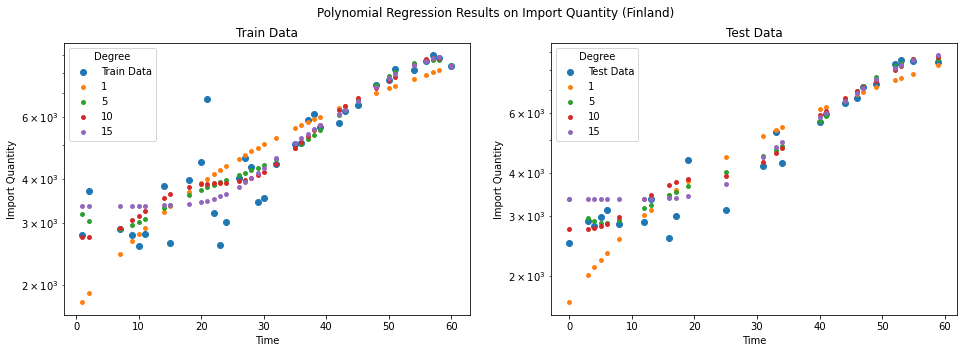

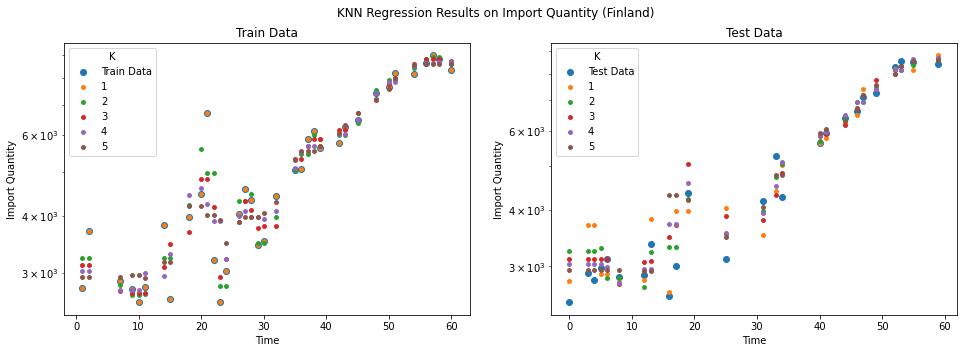

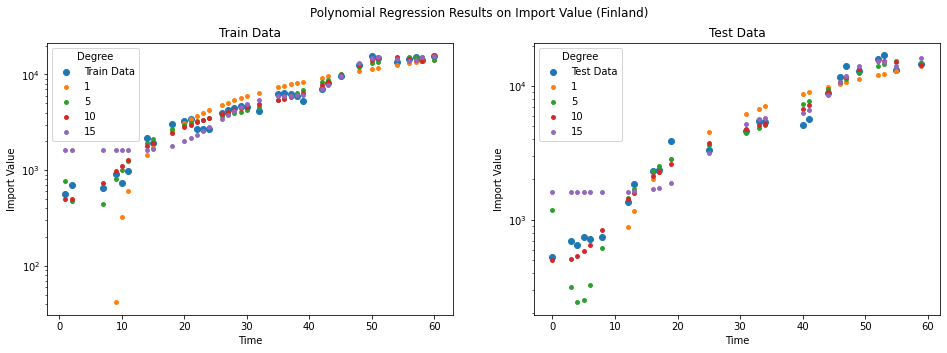

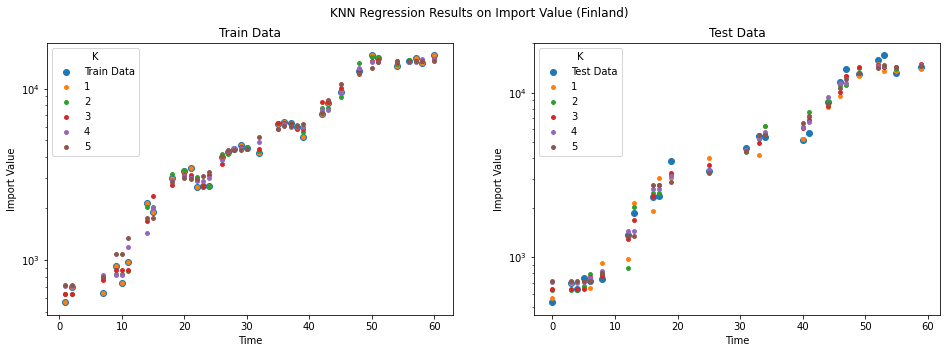

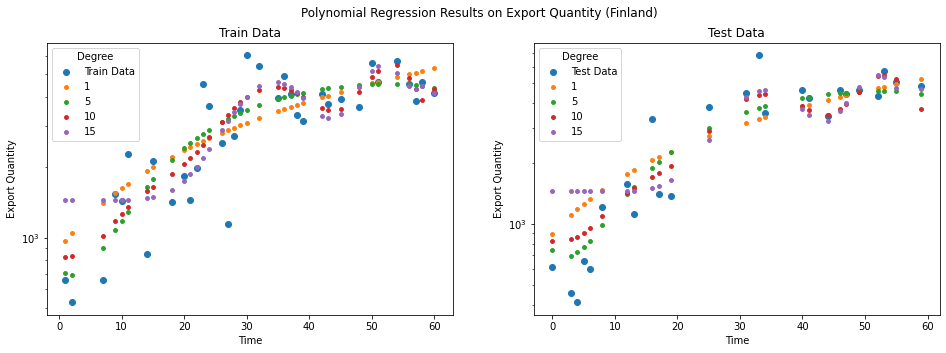

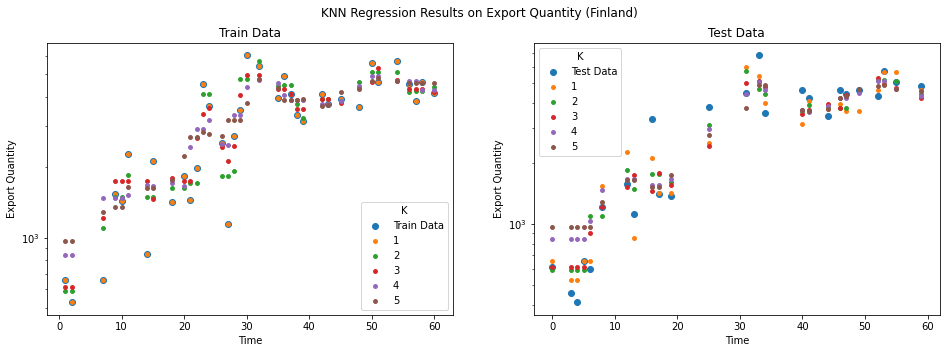

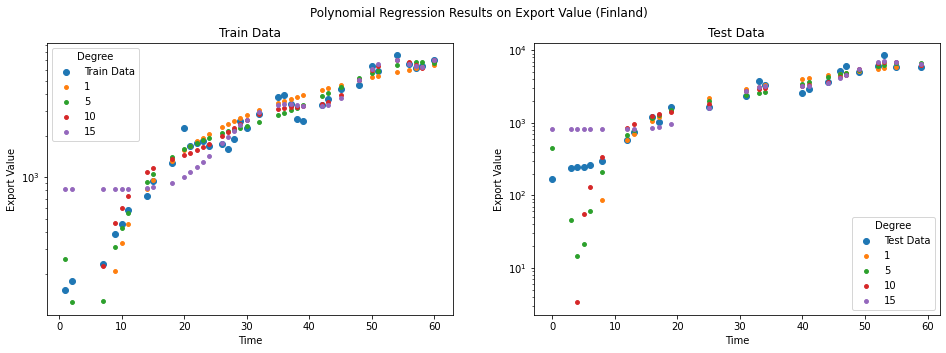

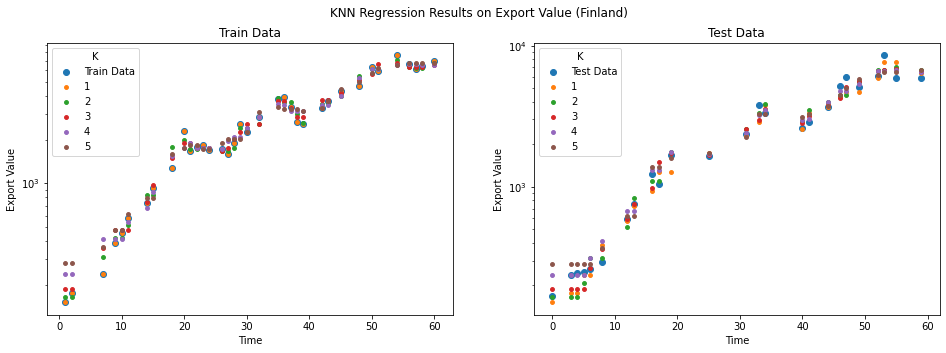

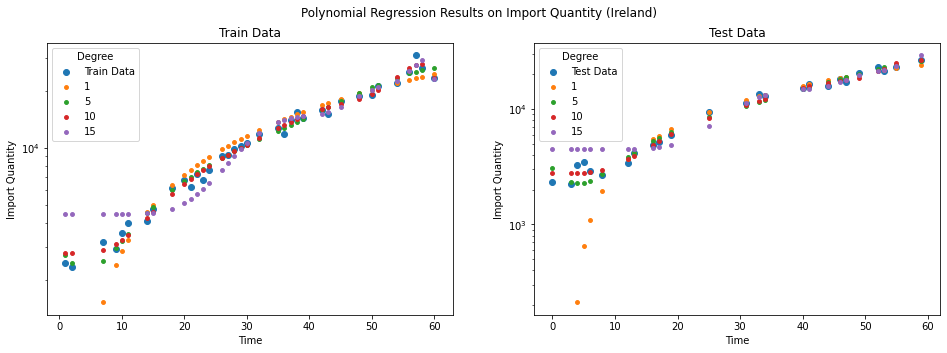

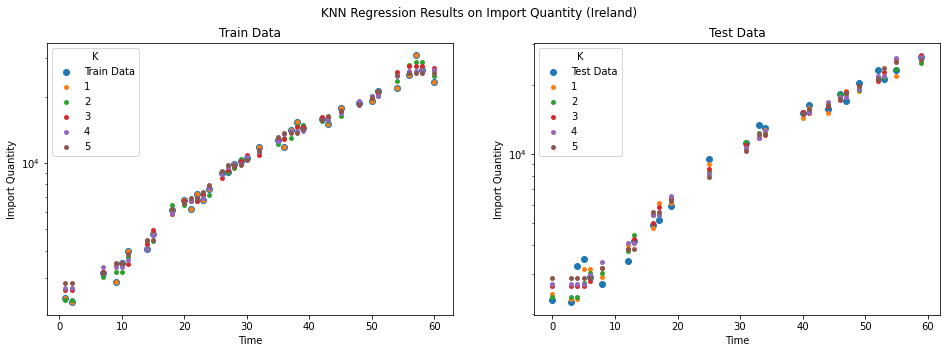

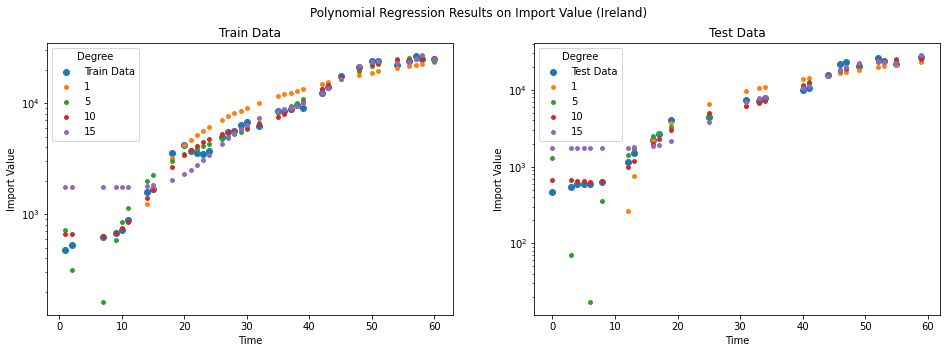

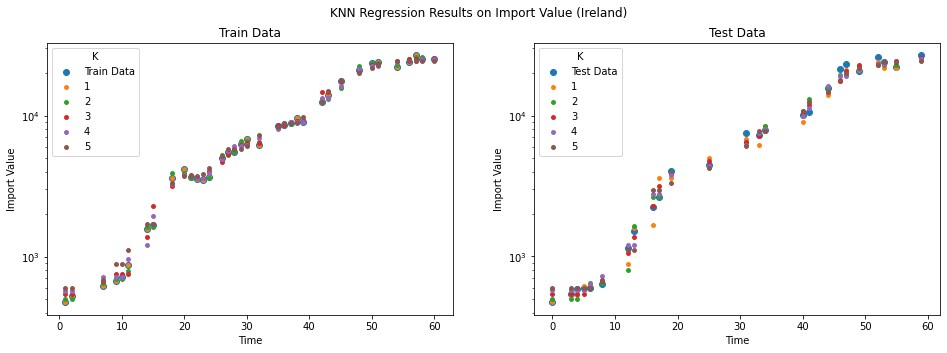

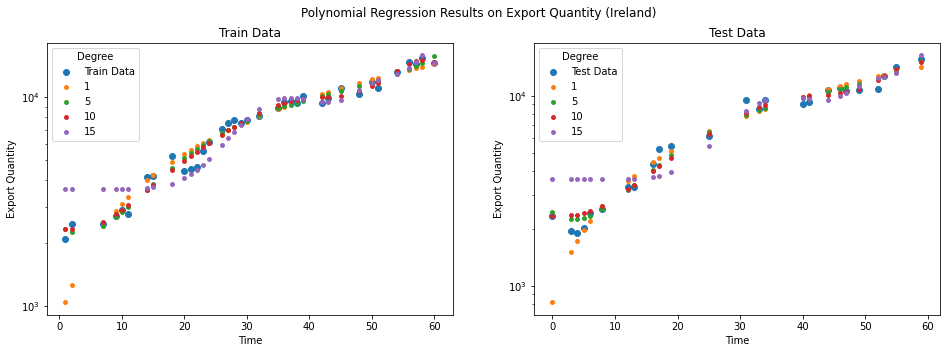

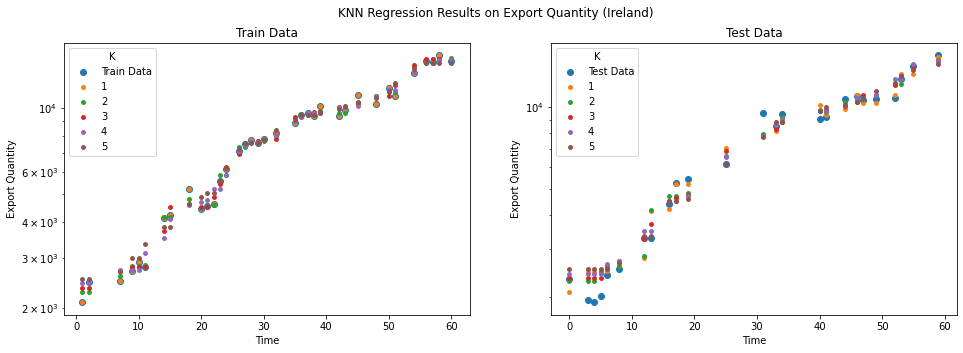

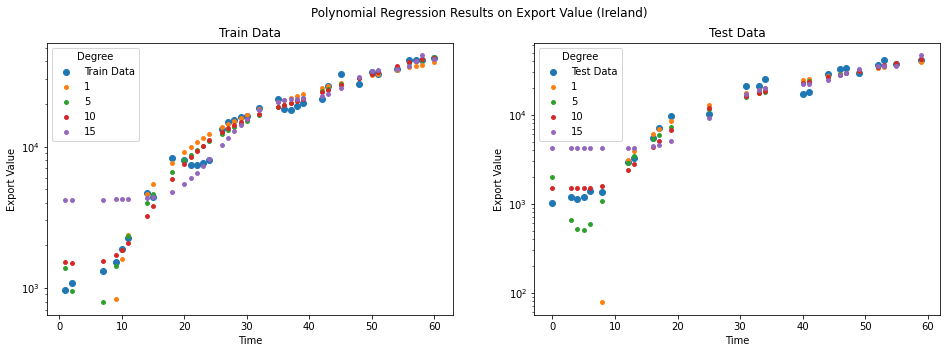

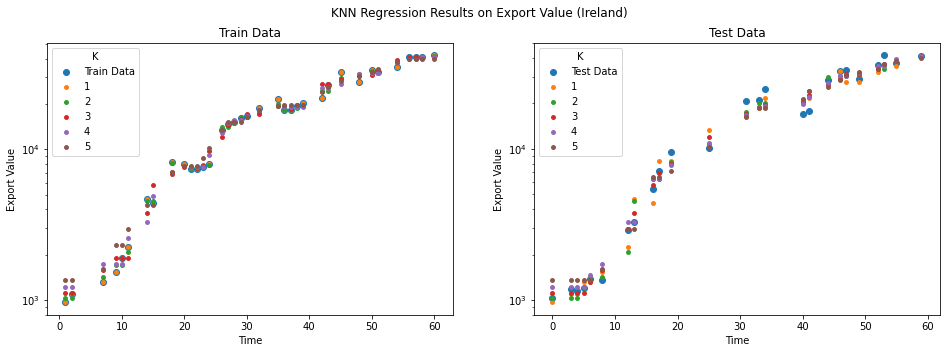

In [13]:
# polynomial regression tested degrees
degrees = [1, 5, 10, 15]

# knn k tested values
k_values = [1, 2, 3, 4, 5]

# models spec dictionary
m_dict = {
    'knn': {
        'label': 'KNN Regression',
        'param_name': 'K', 
        'params': k_values,
        'gs_params': dict(n_neighbors=k_values),
        'model': KNeighborsRegressor()
    }, 
    'lr': {
        'label': 'Polynomial Regression',
        'param_name': 'Degree', 
        'params': degrees,
        'gs_params': dict(polynomialfeatures__degree=degrees),
        'model': make_pipeline(PolynomialFeatures(), LinearRegression())
    }
}

# showing train and test data results
labels = ['Train Data', 'Test Data']

# data frame results list
results_df_lst = []

# running model for all sub-datasets
for df_scaler in imp_exp_ts_datasets:
    # getting independent and target variables
    X, y = df_scaler['Time_Index'], df_scaler['Value']
    
    # getting dataset identification
    country = df_scaler['Area'].unique()[0]
    target = df_scaler['Element'].unique()[0]
    
    for model_n in ['lr', 'knn']:
        # running the poly regression model
        res, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred = run_model_batch(model_n, X, y, target, m_dict[model_n]['params'], ts=.4)

        # getting data to plot the results
        to_plot = [(X_train, y_train, y_train_pred), (X_test, y_test, y_test_pred)]

        # plot original and predicted values with the regression model
        plot_model_results(to_plot, f"{m_dict[model_n]['label']} Results on {target} ({country})", m_dict[model_n]['param_name'], m_dict[model_n]['params'])

        # getting grid search cv results using simple model instance
        gscv = run_grid_search_cv(m_dict[model_n]['model'], X_test, y_test, 'r2', m_dict[model_n]['gs_params'])
    
        # keeping results
        res_df = pd.DataFrame(res, columns=['Element', 'Param', 'Train_R2', 'Test_R2', 'CV_Train', 'CV_Test'])
        res_df['Area'] = country
        res_df['Model'] = model_n.upper()
        res_df['BestParam'] = str(gscv.best_params_)
        
        results_df_lst.append(res_df)

# getting dataframe with consolidated results
res_df = pd.concat(results_df_lst)

The graphs above show how the model performed in the train and test datasets for each experiment, where x-axis represents the time and y-axis the element value (e.g., Import Value, Export Quantity, etc).

Each color represents one execution of the model using a particular parameter (e.g., KNN with 1 neighbor, LR with 5 degrees, etc).

### Results

The table below shows the results of the experiments given by the GridSearchCV. So, all datasets were tested against all models to get the best paramaters.

In [14]:
# showing results data
res_df[['Element', 'Area', 'Model', 'BestParam']].drop_duplicates(ignore_index=True)

,Element,Area,Model,BestParam
0,Import Quantity,Finland,LR,{'polynomialfeatures__degree': 5}
1,Import Quantity,Finland,KNN,{'n_neighbors': 3}
2,Import Value,Finland,LR,{'polynomialfeatures__degree': 10}
3,Import Value,Finland,KNN,{'n_neighbors': 1}
4,Export Quantity,Finland,LR,{'polynomialfeatures__degree': 1}
5,Export Quantity,Finland,KNN,{'n_neighbors': 5}
6,Export Value,Finland,LR,{'polynomialfeatures__degree': 1}
7,Export Value,Finland,KNN,{'n_neighbors': 2}
8,Import Quantity,Ireland,LR,{'polynomialfeatures__degree': 10}
9,Import Quantity,Ireland,KNN,{'n_neighbors': 1}


The graphs below show the R2 score results of individual executions of the Linear Regression model with certain parameters on both train and test data.

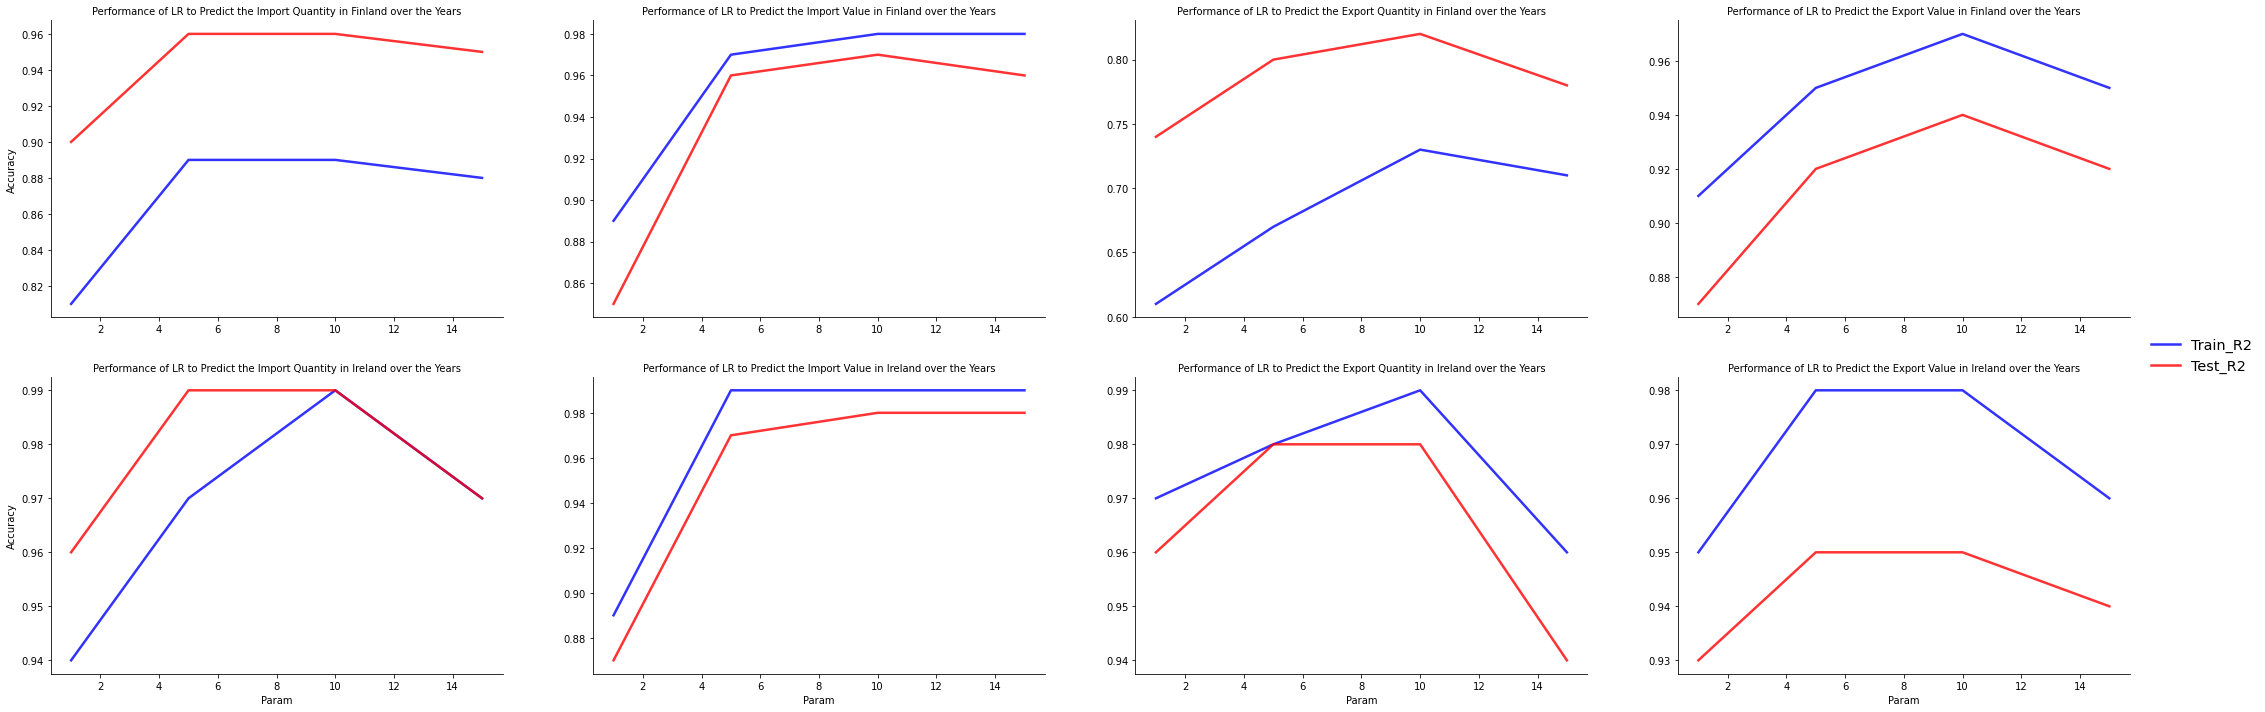

In [21]:
plot_results_dict(res_df, 'LR', ['Train_R2', 'Test_R2'], ['blue', 'red'], 'Performance of LR to Predict the {col_name} in {row_name} over the Years')

The graphs below show the R2 score results of individual executions of the KNN Regression model with certain parameters on both train and test data.

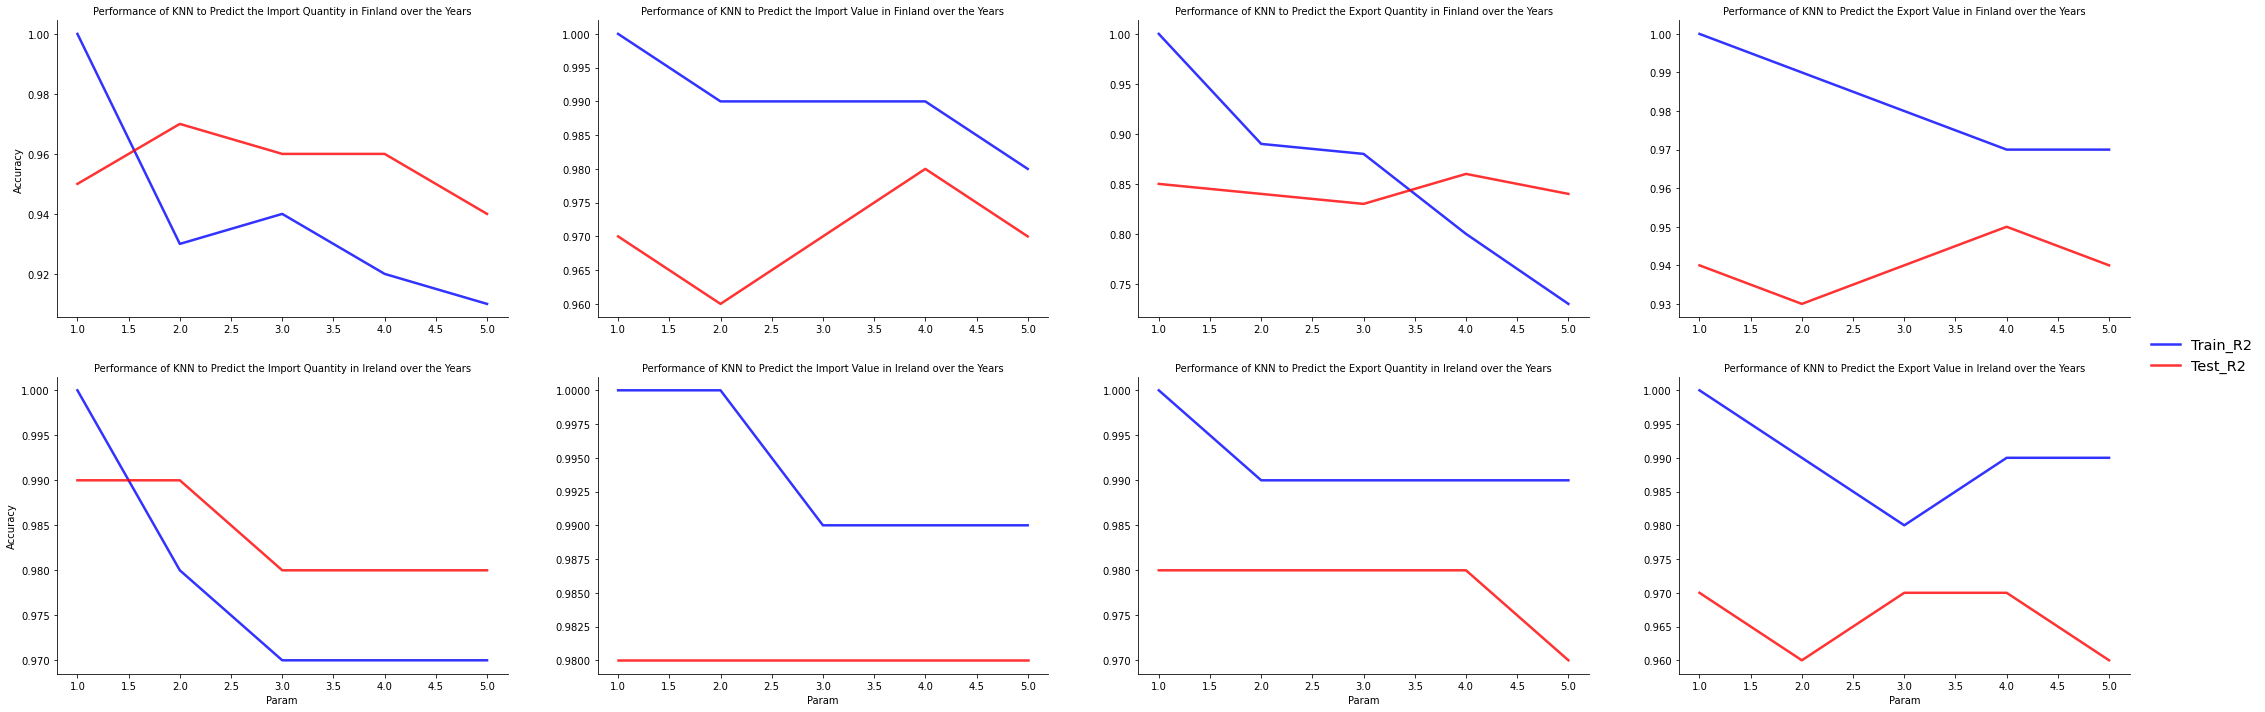

In [22]:
plot_results_dict(res_df, 'KNN', ['Train_R2', 'Test_R2'], ['blue', 'red'], 'Performance of KNN to Predict the {col_name} in {row_name} over the Years')